## Frame the problem. 
1. Define the objective in business terms.
1. How will your solution be used?
1. What are the current solutions/workarounds (if any)?
1. How should you frame this problem (supervised/unsupervised, online/offline, etc.)?
1. How should performance be measured?
1. Is the performance measure aligned with the business objective?
1. What would be the minimum performance needed to reach the business objective?
1. What are comparable problems? Can you reuse experience or tools?
1. Is human expertise available?
1. How would you solve the problem manually?
1. List the assumptions you (or others) have made so far.
1. Verify assumptions if possible.

### GOAL: The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.

### AB testing; 1 group (66%) gets the old price and 33% gets the new price. 

### Questions to answer: 
1. Should the company sell its software for 39 instead of 59?
1. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?
1. The VP of Product feels that the test has been running for too long and she should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days would you have stopped the test? Please, explain why.

In [ ]:
!cd /Users/dcox/Dropbox/InsightFellowship/DataChallenges/Working_Challenges/

In [1]:
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time
from socket import socket

## Test Results Table: EDA & Cleaning

In [23]:
# Get a quick sense of what we're working with
data_test = pd.read_csv('test_results.csv')
test_results = data_test.copy()
test_results = test_results.drop('Unnamed: 0', axis=1)
tr_cols = list(test_results)
print(test_results.dtypes)

user_id               int64
timestamp            object
source               object
device               object
operative_system     object
test                  int64
price               float64
converted             int64
dtype: object


In [24]:
for i in tr_cols:
    print("Missing:", test_results[i].isna().sum(), "\n", test_results[i].value_counts(), "\n")

Missing: 0 
 2047      1
338394    1
465846    1
407572    1
753429    1
         ..
291876    1
293925    1
857669    1
814119    1
2049      1
Name: user_id, Length: 316800, dtype: int64 

Missing: 334 
 2015-04-12 11:51:16    12
2015-05-25 07:27:08    11
2015-04-10 08:29:07    11
2015-04-04 17:38:26    11
2015-05-15 08:47:44    10
                       ..
2015-05-29 16:53:23     1
2015-04-08 16:08:41     1
2015-03-25 13:54:45     1
2015-03-07 11:43:42     1
2015-04-12 18:50:29     1
Name: timestamp, Length: 141147, dtype: int64 

Missing: 312 
 direct_traffic     60307
ads-google         59319
ads_facebook       53337
ads_other          29849
seo-google         23160
ads-bing           22851
seo_facebook       21185
friend_referral    20672
seo-other           9250
ads-yahoo           7573
seo-yahoo           6836
seo-bing            2149
Name: source, dtype: int64 

Missing: 0 
 mobile    186471
web       130329
Name: device, dtype: int64 

Missing: 20339 
 windows    100878
iOS  

In [ ]:
## test_results.profile_report(correlations={"cramers": {"calculate": False}})

### Takeaways from the test_results table:
- "Converted" imbalanced
- "operative_system": recode ms values (n~20,000; recode), ios & windows coded two diff ways, other val pretty low
- "price" has outliers
- "timestamp" has missing vals (n~300; drop)
- 'source' has missing vals (n~300; drop)

In [25]:
# Recode 'operative _system' issues noted above
test_results['operative_system'] = test_results['operative_system'].fillna('unknown') # chose to recode b/c of large n and possible other users will be unknown
test_results['operative_system'] = test_results['operative_system'].replace('wnddows', 'windows')
test_results['operative_system'] = test_results['operative_system'].replace('i0S', 'iOS')
test_results['operative_system'] = test_results['operative_system'].replace('anroid', 'android')
test_results['operative_system'] = test_results['operative_system'].replace('apple', 'unknown')
test_results['operative_system'].value_counts()

windows    100976
iOS         95465
android     74935
mac         25056
unknown     20368
Name: operative_system, dtype: int64

In [26]:
# Remove outliers based on 'price' column
test_results = test_results[test_results['price'] < 60]
test_results['price'].value_counts()

39.0    200747
59.0    112979
Name: price, dtype: int64

In [27]:
# Remove rows with missing vals from timestamp and source
test_results = test_results.dropna()
cols = ['timestamp', 'source']
for i in cols:
    print("Missing:", test_results[i].isna().sum(), "\n", test_results[i].value_counts(), "\n")

Missing: 0 
 2015-04-12 11:51:16    12
2015-04-04 17:38:26    11
2015-05-25 07:27:08    11
2015-04-10 08:29:07    11
2015-05-14 16:41:42    10
                       ..
2015-04-12 17:51:60     1
2015-05-23 00:39:34     1
2015-05-15 07:23:13     1
2015-04-13 00:19:11     1
2015-04-12 18:50:29     1
Name: timestamp, Length: 140634, dtype: int64 

Missing: 0 
 direct_traffic     59666
ads-google         58686
ads_facebook       52738
ads_other          29533
seo-google         22911
ads-bing           22592
seo_facebook       20953
friend_referral    20458
seo-other           9142
ads-yahoo           7499
seo-yahoo           6781
seo-bing            2128
Name: source, dtype: int64 



In [56]:
len(test_results)

313087

## User Table Data: EDA & Cleaning

In [32]:
# Get a quick sense of what we're working with
data_user = pd.read_csv('user_table.csv')
user_table = data_user.copy()
usr_cols = list(user_table)
print(user_table.dtypes)

user_id      int64
city        object
country     object
lat        float64
long       float64
dtype: object


In [36]:
for i in usr_cols:
    print("Missing:", user_table[i].isna().sum(), "\n", user_table[i].value_counts(), "\n")

Missing: 0 
 2047      1
658708    1
783659    1
779561    1
257320    1
         ..
639403    1
609923    1
83586     1
87680     1
2049      1
Name: user_id, Length: 275616, dtype: int64 

Missing: 0 
 New York       25748
Chicago         7153
Houston         6706
San Antonio     4633
Los Angeles     4141
               ...  
Cerritos           1
New Milford        1
East Lake          1
Ocala              1
Costa Mesa         1
Name: city, Length: 923, dtype: int64 

Missing: 0 
 USA    275616
Name: country, dtype: int64 

Missing: 0 
 40.67    25901
41.84     7478
29.77     6706
29.46     4633
34.11     4475
         ...  
36.53        3
39.30        3
35.12        3
26.45        3
27.98        1
Name: lat, Length: 713, dtype: int64 

Missing: 0 
 -73.94     25748
-87.68      7153
-95.39      6706
-98.51      4633
-118.41     4141
           ...  
-82.38         1
-73.41         1
-118.07        1
-73.51         1
-82.13         1
Name: long, Length: 830, dtype: int64 



(array([  892.,     0., 26450., 50549., 40770., 62020., 94598.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,   337.]),
 array([-157.8       , -145.25933333, -132.71866667, -120.178     ,
        -107.63733333,  -95.09666667,  -82.556     ,  -70.01533333,
         -57.47466667,  -44.934     ,  -32.39333333,  -19.85266667,
          -7.312     ,    5.22866667,   17.76933333,   30.31      ]),
 <a list of 15 Patch objects>)

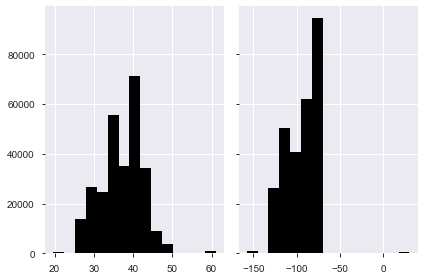

In [82]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(user_table['lat'], bins=15, color='black')
axs[1].hist(user_table['long'], bins=15, color='black')

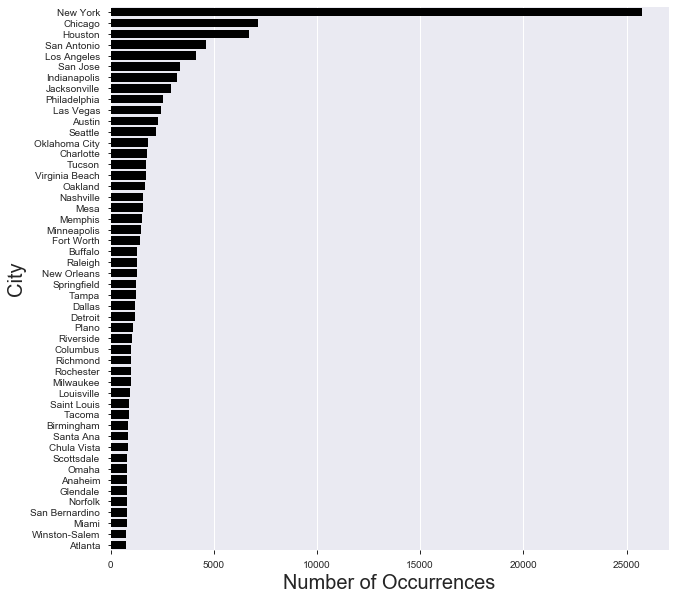

In [72]:
city_count = user_table['city'].value_counts()
city_count = city_count[:50,]
plt.figure(figsize=(10,10))
sns.barplot(city_count.values, city_count.index, color='black')
plt.ylabel('City', fontsize=20)
plt.xlabel('Number of Occurrences', fontsize=20)
plt.show()

In [ ]:
user_table.profile_report(correlations={"cramers": {"calculate": False}})

In [91]:
cols = list(user_table)
for i in user_table:
    print("Num Unique", i, ":", len((user_table[i].unique())), "\n\n")

Num Unique user_id : 275616 


Num Unique city : 923 


Num Unique country : 1 


Num Unique lat : 713 


Num Unique long : 830 




### Takeaways from the user_table:
- Imbalanced classes for city - recode into regions of country?
- Only one country - drop

In [94]:
# Drop country form user_table
user_table = user_table.drop(['country'], axis=1)
print(list(user_table))

['user_id', 'city', 'lat', 'long']


## Merge the two tables into one

In [104]:
merged_data = pd.merge(test_results, user_table, on="user_id", how='inner') # chose to keep only vals common to both

## Recode strings as numbers for ML algorithms

In [ ]:
mostObs_predCols = list(mostObs_pred)
mostObs_predCodes = []
for i in mostObs_predCols:
    mostObs_pred[i] = mostObs_pred[i].astype('category')
    d = dict(enumerate(mostObs_pred[i].cat.categories))
    mostObs_predCodes.append(d)
    mostObs_pred[i] = mostObs_pred[i].astype('category')
    mostObs_pred[i] = mostObs_pred[i].cat.codes

## Explore the Data
1. Create a copy of the data for exploration (sampling it down to a manageable size if necessary).
1. Create a Jupyter notebook to keep a record of your data exploration.
1. Study each attribute and its characteristics:
    1. Name
    1. Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
    1. % of missing values
    1. Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)
    1. Usefulness for the task
    1. Type of distribution (Gaussian, uniform, logarithmic, etc.)
1. For supervised learning tasks, identify the target attribute(s).
1. Visualize the data.
1. Study the correlations between attributes.
1. Study how you would solve the problem manually.
1. Identify the promising transformations you may want to apply.
1. Identify extra data that would be useful (go back to “Get the Data” ).
1. Document what you have learned.

## Prepare the Data
1. Work on copies of the data (keep the original dataset intact).
1. Write functions for all data transformations you apply, for five reasons:
1. So you can easily prepare the data the next time you get a fresh dataset
1. So you can apply these transformations in future projects
1. To clean and prepare the test set
1. To clean and prepare new data instances once your solution is live
1. To make it easy to treat your preparation choices as hyperparameters
1. Data cleaning:
    1. Fix or remove outliers (optional).
    1. Fill in missing values (e.g., with zero, mean, median…) or drop their rows (or columns).
1. Feature selection (optional):
    1. Drop the attributes that provide no useful information for the task.
1. Feature engineering, where appropriate:
    1. Discretize continuous features.
    1. Decompose features (e.g., categorical, date/time, etc.).
    1. Add promising transformations of features (e.g., log( x ), sqrt( x ), x 2 , etc.).
    1. Aggregate features into promising new features.
1. Feature scaling:
    1. Standardize or normalize features.

## Shortlist Promising Models
1. If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (be aware that this penalizes complex models such as large neural nets or Random Forests).
1. Once again, try to automate these steps as much as possible.
1. Train many quick-and-dirty models from different categories (e.g., linear, naive Bayes, SVM, Random Forest, neural net, etc.) using standard parameters.
1. Measure and compare their performance.
    1. For each model, use N fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.
1. Analyze the most significant variables for each algorithm.
1. Analyze the types of errors the models make.
    1. What data would a human have used to avoid these errors?
1. Perform a quick round of feature selection and engineering.
1. Perform one or two more quick iterations of the five previous steps.
1. Shortlist the top three to five most promising models, preferring models that make different types of errors.

## Fine-Tune the System
1. You will want to use as much data as possible for this step, especially as you move toward the end of fine-tuning.
1. As always, automate what you can.
1. Fine-tune the hyperparameters using cross-validation:
    1. Treat your data transformation choices as hyperparameters, especially when you are not sure about them (e.g., if you’re not sure whether to replace missing values with zeros or with the median value, or to just drop the rows).
    1. Unless there are very few hyperparameter values to explore, prefer random search over grid search. If training is very long, you may prefer a Bayesian optimization approach (e.g., using Gaussian process priors, as described by Jasper Snoek et al.).
1. Try Ensemble methods. Combining your best models will often produce better performance than running them individually.
1. Once you are confident about your final model, measure its performance on the test set to estimate the generalization error.

## Present Your Solution
1. Document what you have done.
1. Create a nice presentation.
1. Make sure you highlight the big picture first.
1. Explain why your solution achieves the business objective.
1. Don’t forget to present interesting points you noticed along the way.
1. Describe what worked and what did not.
1. List your assumptions and your system’s limitations.
1. Ensure your key findings are communicated through beautiful visualizations or easy-to-remember statements (e.g., “the median income is the number-one predictor of housing prices”).